<a href="https://colab.research.google.com/github/SEREMM/stationary_strategies/blob/main/aapl_stationary_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.optimize import brute
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
# define colormap customized
colors = ["darkblue", "white"]
n_bins = 30  # bins no. for colormap
cmap_name = 'blue_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
# define font
plt.rcParams['font.family'] = 'monospace'  # Cambia esto por la fuente que prefieras
plt.rcParams['font.size'] = 12  # Tamaño de fuente predeterminado
plt.rcParams['axes.titlesize'] = 14  # Tamaño de fuente para los títulos de los ejes
plt.rcParams['axes.labelsize'] = 12  # Tamaño de fuente para las etiquetas de los ejes


### Gral functions

In [3]:
# drawdown function
def calculate_max_drawdown(prices):
    # calculate max cum value for each point
    rolling_max = prices.cummax()
    # relative drawdown
    drawdown = prices / rolling_max - 1
    # max drawdown
    max_drawdown = drawdown.cummin()
    return max_drawdown.min()

def calculate_log_returns(data):
    df = data.copy().reset_index()
    # Init col log_ret with NaN
    df['log_ret'] = np.nan
    # Init variables
    start_new_segment = True
    # travel df row by row
    for i in range(len(df)):
        if df.loc[i, 'strategy'] == 1:
            if start_new_segment:
                df.loc[i, 'log_ret'] = 0  # init 0 ret for 1st element of the segment
                start_new_segment = False
            else:
                df.loc[i, 'log_ret'] = np.log(df.loc[i, 'Close'] / df.loc[i-1, 'Close'])
        else:
            start_new_segment = True  # restart calc in a new segment

    return df

# dates for strategy
def dates_for_strategy(data, m1, d1, m2, d2, m3, d3, m4, d4):
  temp = data.copy().Close.to_frame()
  # init strategy col with no entry -1
  temp['strategy'] = -1
  for anio in temp.index.year.unique(): # get the years
    temp.loc[f'{anio}-{m1}-{d1}': f'{anio}-{m2}-{d2}', 'strategy'] = 1 # give the dates range for start
    if m4 > 12: # if jan is passed in the 2nd entry of the year
      m4 = m4 - 12 # substract the plus values of months
      temp.loc[f'{anio}-{m3}-{d3}': f'{anio + 1}-{m4}-{d4}', 'strategy'] = 1
      m4 = m4 + 12 # add the plus values of months
    else:
      temp.loc[f'{anio}-{m3}-{d3}': f'{anio}-{m4}-{d4}', 'strategy'] = 1
  return temp

# objective (max cumulative return)
def objective(data):
  df = data.copy()
  cum_return = np.exp(df.log_ret.dropna().sum()) - 1
  return -cum_return # negative because brute goes for the min

# for brute function
def brute_objective(params, data, m1, d1, m2, d2, m3, d3):
    m4, d4 = params # dates to sort
    temp = dates_for_strategy(data, m1, d1, m2, d2, m3, d3, m4, d4) # get the strategy col
    temp = calculate_log_returns(temp) # get the lof returns
    cum_ret = objective(temp) # get the max cum ret
    print(-cum_ret, params)
    return cum_ret

### Get the data

In [4]:
data = yf.download('AAPL', period='10y')

[*********************100%%**********************]  1 of 1 completed


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-23,22.830000,22.905001,22.650000,22.707500,20.085588,174776000
2014-06-24,22.687500,22.934999,22.547501,22.570000,19.963963,156144000
2014-06-25,22.552500,22.674999,22.412500,22.590000,19.981649,147476000
2014-06-26,22.592501,22.762501,22.450001,22.725000,20.101065,130516000
2014-06-27,22.705000,23.000000,22.692499,22.995001,20.339890,256116000
...,...,...,...,...,...,...
2024-06-14,213.850006,215.169998,211.300003,212.490005,212.490005,70122700
2024-06-17,213.369995,218.949997,212.720001,216.669998,216.669998,93728300
2024-06-18,217.589996,218.630005,213.000000,214.289993,214.289993,79943300


### Check time series

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv1d8blrk/wrgjrzne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv1d8blrk/gc6uqxqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40448', 'data', 'file=/tmp/tmpv1d8blrk/wrgjrzne.json', 'init=/tmp/tmpv1d8blrk/gc6uqxqn.json', 'output', 'file=/tmp/tmpv1d8blrk/prophet_modelydf3y5t6/prophet_model-20240620162025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


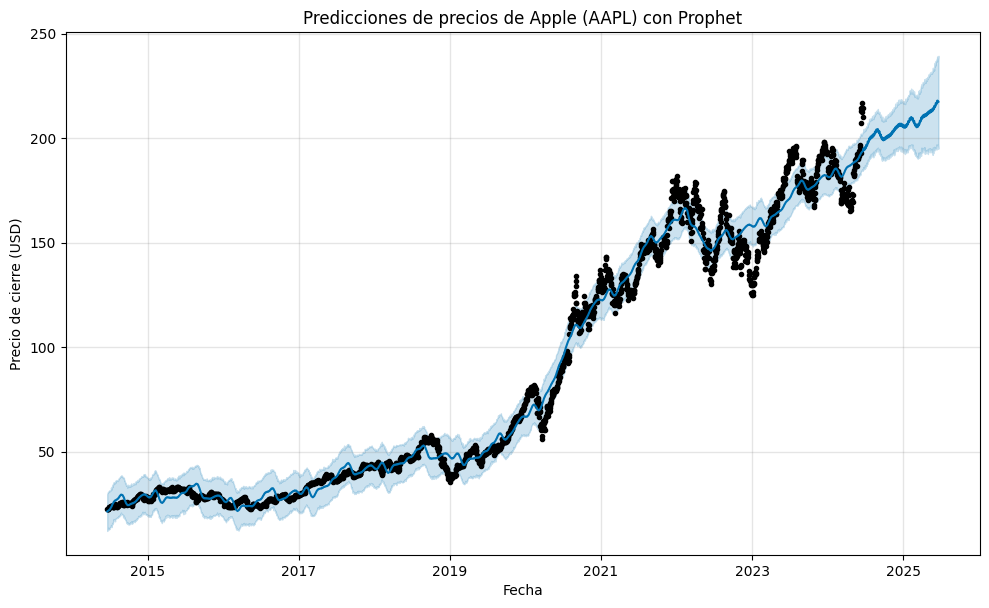

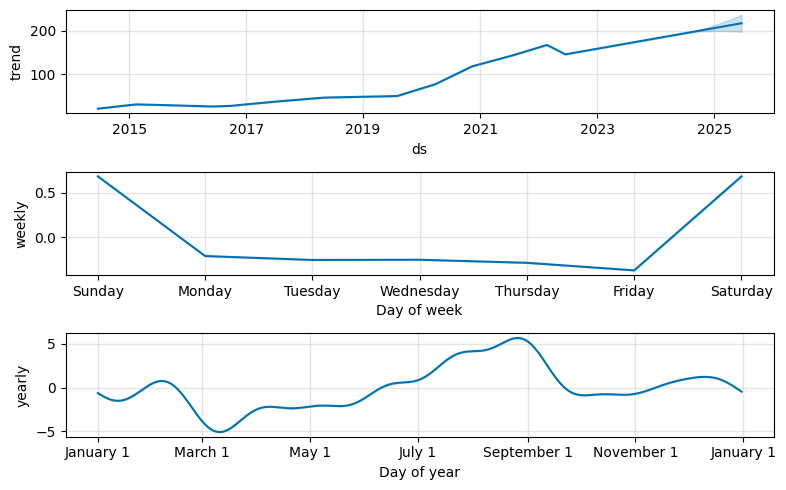

In [ ]:
# data processing
# delete hour zone info
df = data.reset_index()
df["Date"] = df["Date"].dt.tz_localize(None)  # delete hour zone

# rename columns
df_prophet = df[["Date", "Close"]]
df_prophet.columns = ["ds", "y"]  # ds: date, y: close price

# create and fit model
modelo = Prophet()
modelo.fit(df_prophet)

# create df to predict the next 365 days
futuro = modelo.make_future_dataframe(periods=365)

# predictions
pronostico = modelo.predict(futuro)

# visualize predictions
figura = modelo.plot(pronostico, xlabel="Date", ylabel="Close price (USD)")
plt.title("Predict stock prices")
plt.show()

# visualize trend, stationality, and more
figura_componentes = modelo.plot_components(pronostico, figsize=(8,5))
plt.show()

### brute best values

In [ ]:
temp1 = data.copy()

ranges = (slice(11, 12, 1), slice(18, 31, 1))

# execute brute
optimal_params = brute(brute_objective, ranges, args=(data, 3, 12, 8, 30, 11, 3), full_output=True, finish=None)

# get optimal values
lista = optimal_params

8.347049833513356 [11 18]
8.200376285626708 [11 19]
7.796592302351193 [11 20]
7.823651619785744 [11 21]
8.10320870219989 [11 22]
7.5236531111394935 [11 23]
7.833977121333332 [11 24]
7.78252903341423 [11 25]
7.653826940627145 [11 26]
7.724409605408011 [11 27]
7.775955664082977 [11 28]
7.4569569488371705 [11 29]
8.408546860466661 [11 30]


In [ ]:
lista

(array([11., 30.]),
 -8.408546860466661,
 array([[[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]],
 
        [[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]]),
 array([[-8.34704983, -8.20037629, -7.7965923 , -7.82365162, -8.1032087 ,
         -7.52365311, -7.83397712, -7.78252903, -7.65382694, -7.72440961,
         -7.77595566, -7.45695695, -8.40854686]]))

### apply brute value

In [6]:
df_est = data.copy()
df_est = dates_for_strategy(df_est, 3, 12, 8, 30, 11, 3, 11, 30)
df_est = calculate_log_returns(df_est)

### Comparisons

In [7]:
df = data.copy().Close.to_frame()
df['log_ret'] = np.log(data.Close / data.Close.shift()).fillna(0)

inv_est = df_est.copy().set_index('Date').dropna()

Cumulative return

In [8]:
mult1 = np.exp(df.log_ret.sum()) - 1
mult2 = np.exp(inv_est.log_ret.sum()) - 1
print('Stock cumulative return:', mult1)
print('Strategy cumulative return:', mult2)

Stock cumulative return: 8.137509691086418
Strategy cumulative return: 8.310279988322424


In [48]:
def plot_cum_returns(x, y1, y2, not_in_market):
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.plot(x, y1, label='Stock', color=cm(10))
  ax.plot(x, y2, label='Strategy', color=cm(0))
  # Customize
  ax.set_xlabel('Date')
  ax.set_ylabel('Value')
  ax.set_title('Stock vs Strategy (Cumulative returns)')
  # Shading
  for dates in not_in_market:
      ax.axvspan(pd.to_datetime(dates[0]), pd.to_datetime(dates[1]), color='grey', alpha=.3)
  # Add custom legend for shading
  grey_patch = mpatches.Patch(color='grey', alpha=.3, label='Time out of market')
  ax.legend(handles=[grey_patch, *ax.get_legend_handles_labels()[0]], loc='best')
  # Show
  plt.show()

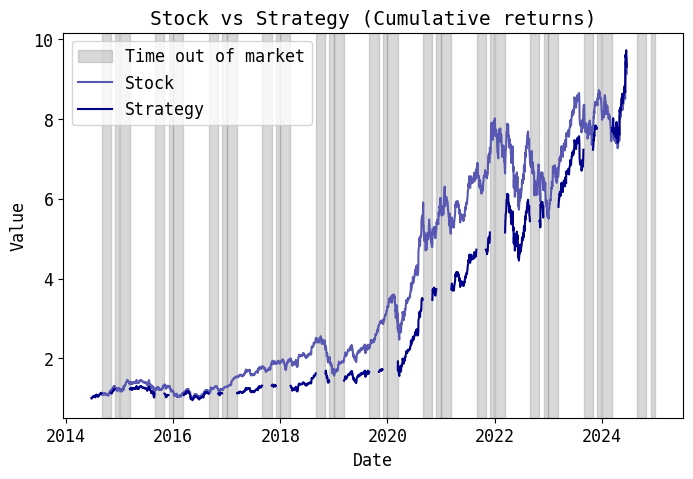

In [49]:
# Generate the list of date ranges not in the market
lista = []
for anio in df.index.year.unique():
    val1 = [f'{anio}-1-1', f'{anio}-03-11'] # not in market
    val2 = [f'{anio}-08-31', f'{anio}-11-2'] # not in market
    val3 = [f'{anio}-12-1', f'{anio}-12-31'] # not in market
    lista.append(val1)
    lista.append(val2)
    lista.append(val3)

plot_cum_returns(df.index, np.exp(df.log_ret.cumsum()), np.exp(df_est.log_ret.cumsum()), lista[1:])

In [13]:
print('Days in market and days out of market (strategy)')
df_est.strategy.value_counts()

Days in market and days out of market (strategy)


strategy
 1    1385
-1    1132
Name: count, dtype: int64

<Axes: title={'center': 'Strategy cumulative log returns'}, xlabel='days in market', ylabel='value'>

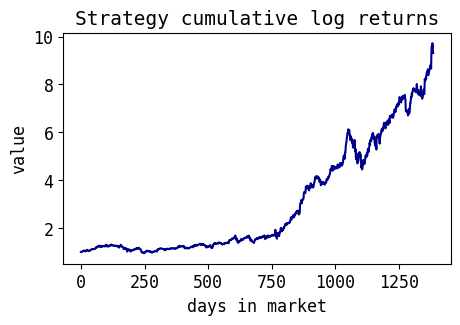

In [14]:
df_est.dropna().reset_index().log_ret.cumsum().apply(np.exp).plot(figsize=(5,3), title='Strategy cumulative log returns', ylabel='value', xlabel='days in market', color=cm(0))

Average anual returns

In [17]:
dias_estrategia = len(inv_est.index) / len(inv_est.index.year.unique())

ar1 = df.log_ret.mean() * 252
ar2 = inv_est.log_ret.mean() * dias_estrategia

print('Stock anual returns:', ar1)
print('Strategy anual returns:', ar2)

Stock anual returns: 0.22150248199688338
Strategy anual returns: 0.20282901497912995


Standard deviation

In [18]:
std1 = df.log_ret.std() * np.sqrt(252)
std2 = inv_est.log_ret.std() * np.sqrt(dias_estrategia)

print('Stock standard deviation:', std1)
print('Strategy standard deviation:', std2)

Stock standard deviation: 0.28447486143958883
Strategy standard deviation: 0.19179829355989864



Mean absolute deviation

In [19]:
def plot_mad(returns, mean_returns, name):
  plt.figure(figsize=(8, 5))
  plt.plot(returns, label='Returns', color=cm(0))
  plt.axhline(mean_returns, color='r', linestyle='--', label='Mean returns')
  plt.xlabel('Date')
  plt.ylabel('Returns')
  plt.title(f'{name} - simulated daily returns')
  plt.legend()
  plt.show()

Mean absolute deaviation (MAD): 0.012518515536057605


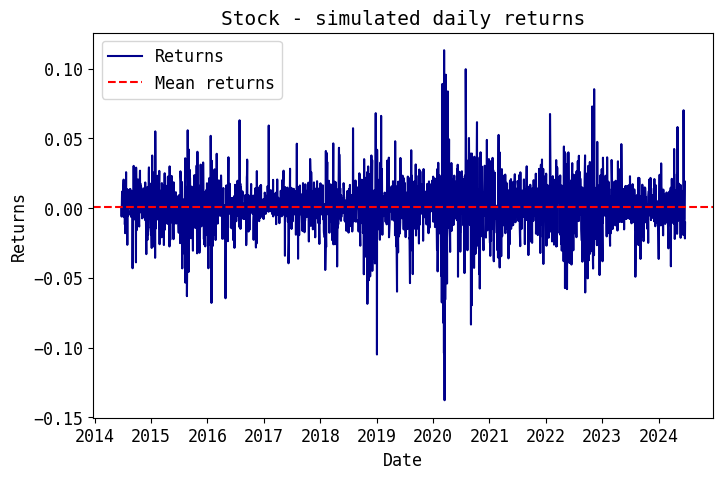

In [20]:
mean_returns = df.log_ret.mean()
mad = np.mean(np.abs(df['log_ret'] - mean_returns))
print(f"Mean absolute deaviation (MAD): {mad}")
plot_mad(df.log_ret, mean_returns, 'Stock')

Mean Absolute deavia (DAM): 0.011711361424481675


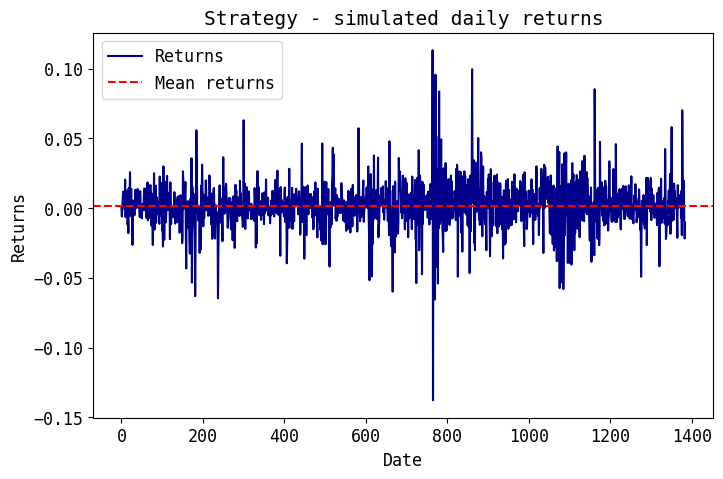

In [21]:
temp = inv_est.copy().dropna().reset_index()
mean_returns = temp.log_ret.mean()
dam = np.mean(np.abs(temp['log_ret'] - mean_returns))
print(f"Mean Absolute deavia (DAM): {dam}")
plot_mad(temp.log_ret, mean_returns, 'Strategy')

VaR & CVaR

In [22]:
def plot_var_cvar(returns, var, cvar, confidence_level, name):
  plt.figure(figsize=(8, 5))
  plt.hist(returns, bins=50, alpha=0.75, color=cm(0), edgecolor='black')
  plt.axvline(var, color='r', linestyle='--', label=f'VaR at {confidence_level*100}%')
  plt.axvline(cvar, color='g', linestyle='--', label=f'CVaR at {confidence_level*100}%')
  plt.xlabel('Returns')
  plt.ylabel('Freqs')
  plt.title(f'{name} - simulated daily returns distribution')
  plt.legend()
  plt.show()

VaR at 95.0%: -0.027266635386752495
CVaR at 95.0%: -0.04178431537624434
Skewness: -0.18939547603021645
Kurtosis: 5.453415640511681


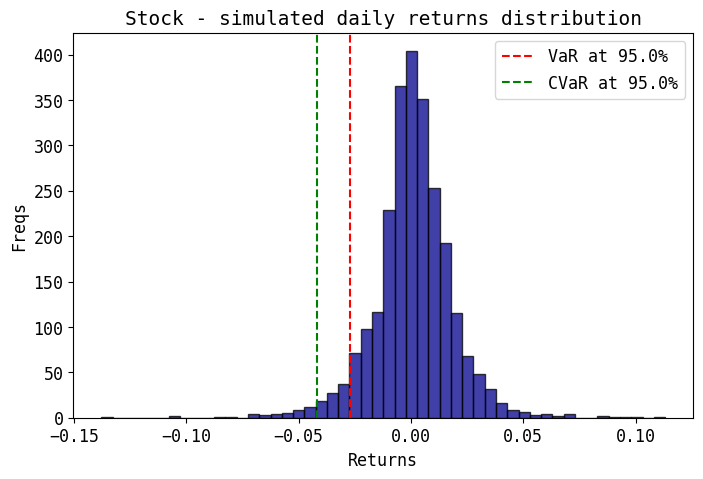

In [23]:
confidence_level = 0.95
# calc VaR
var = np.percentile(df['log_ret'], (1 - confidence_level) * 100)
# calc CVaR (Expected Shortfall)
cvar = df[df['log_ret'] <= var]['log_ret'].mean()
print(f"VaR at {confidence_level*100}%: {var}")
print(f"CVaR at {confidence_level*100}%: {cvar}")
# calc Skewness
skewness = skew(df['log_ret'])
# calc Kurtosis
kurt = kurtosis(df['log_ret'])
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")
plot_var_cvar(df.log_ret, var, cvar, confidence_level, 'Stock')

VaR at 95.0%: -0.025380057550303942
CVaR at 95.0%: -0.03887963539479373
Skewness: -0.005861262622615571
Kurtosis: 7.590663577364154


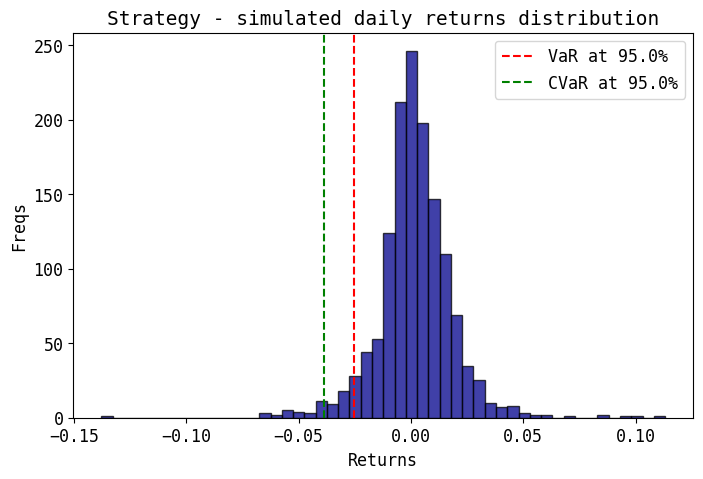

In [24]:
temp = inv_est.copy().dropna().reset_index()
confidence_level = 0.95
# calc VaR
var = np.percentile(temp['log_ret'], (1 - confidence_level) * 100)
# calc CVaR (Expected Shortfall)
cvar = temp[temp['log_ret'] <= var]['log_ret'].mean()
print(f"VaR at {confidence_level*100}%: {var}")
print(f"CVaR at {confidence_level*100}%: {cvar}")
# calc Skewness
skewness = skew(temp['log_ret'])
# calc Kurtosis
kurt = kurtosis(temp['log_ret'])
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")
plot_var_cvar(temp.log_ret, var, cvar, confidence_level, 'Strategy')

sharpe ratio

In [25]:
# Define free risk rate (daily)
risk_free_rate = 0.03 / 252  # 252 days of market in 1 year
## stock
# calc avg daily ret and daily std
mean_returns = df.log_ret.mean()
std_returns = df.log_ret.std()
# calc avg daily return excess
excess_returns = mean_returns - risk_free_rate
# calc sharpe ratio
sr1 = excess_returns / std_returns
## strategy
# calc daily avg ret and daily std
mean_returns = inv_est.log_ret.mean()
std_returns = inv_est.log_ret.std()
# calc avg daily return excess
excess_returns = mean_returns - risk_free_rate
# calc sharpe ratio
sr2 = excess_returns / std_returns

print('sharpe ratio stock:', sr1)
print('sharpe ratio strategy:', sr2)

sharpe ratio stock: 0.042406286400624514
sharpe ratio strategy: 0.08727993633803355


rolling mean and std plots

In [26]:
def plot_roll_mean_std(x, y1, y2, name):
  fig, ax = plt.subplots(figsize=(8,5))
  ax.plot(x, y1, label='rolling mean', color=cm(0))
  ax.plot(x, y2, label='rolling std', color='r')
  ax.set_xlabel('Date')
  ax.set_ylabel('Value')
  ax.set_title(f'{name} - rolling mean and std')
  plt.show()

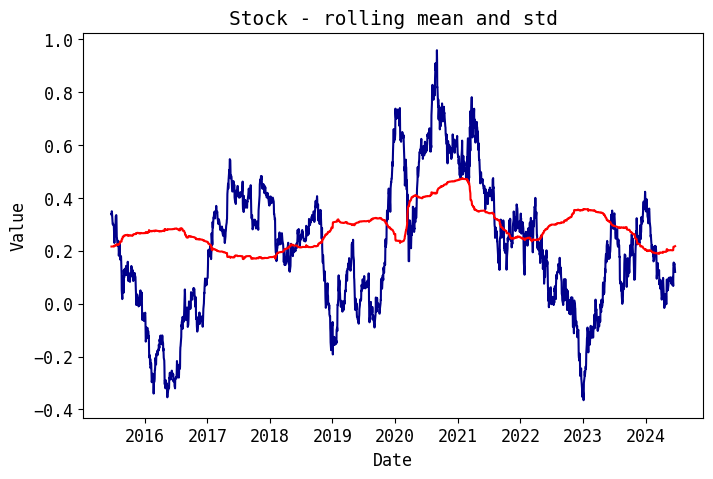

In [27]:
roll_mean = df.log_ret.rolling(window=252).mean() * 252
roll_std = df.log_ret.rolling(window=252).std() * np.sqrt(252)
plot_roll_mean_std(df.index, roll_mean, roll_std, 'Stock')

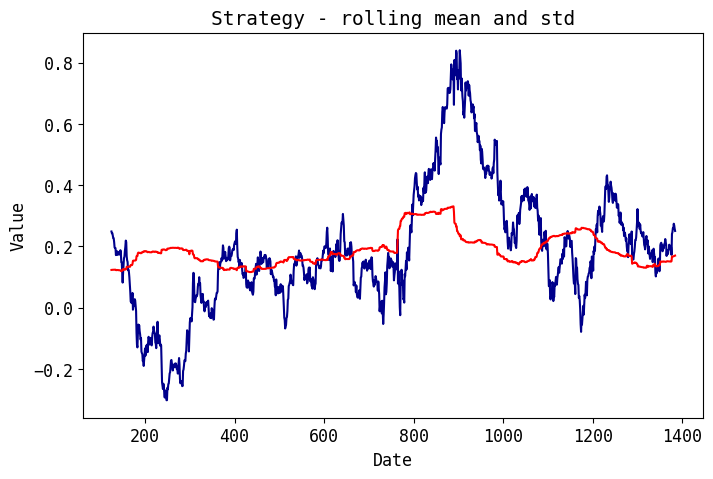

In [28]:
temp = inv_est.dropna().reset_index()
dias_estrategia = int(round(dias_estrategia, 0))

roll_mean = temp.log_ret.rolling(window=dias_estrategia).mean() * dias_estrategia
roll_std = temp.log_ret.rolling(window=dias_estrategia).std() * np.sqrt(dias_estrategia)
plot_roll_mean_std(temp.index, roll_mean, roll_std, 'Strategy')

anual returns

In [32]:
print('Stock anual returns:\n')
df.log_ret.resample('Y').sum() - df.log_ret.resample('Y').first()

Stock anual returns:



Date
2014-12-31    0.194939
2015-12-31   -0.037937
2016-12-31    0.094749
2017-12-31    0.376376
2018-12-31   -0.088057
2019-12-31    0.620300
2020-12-31    0.569361
2021-12-31    0.316379
2022-12-31   -0.337066
2023-12-31    0.431378
2024-12-31    0.111274
Freq: A-DEC, Name: log_ret, dtype: float64

In [33]:
print('Strategy anual returns:\n')
inv_est.log_ret.resample('Y').sum() - inv_est.log_ret.resample('Y').first()

Strategy anual returns:



Date
2014-12-31    0.204397
2015-12-31   -0.129412
2016-12-31    0.039644
2017-12-31    0.156208
2018-12-31    0.092567
2019-12-31    0.180255
2020-12-31    0.773782
2021-12-31    0.322426
2022-12-31    0.117383
2023-12-31    0.293405
2024-12-31    0.180463
Freq: A-DEC, Name: log_ret, dtype: float64

R^2

In [34]:
def plot_r2(y, x_1, x_2, name):
  plt.figure(figsize=(8, 5))
  plt.plot(y, x_1, label='Straight values', color='g')
  plt.plot(y, x_2, label='Actual values', marker='x', color=cm(0))
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.title(f'{name} - straight values vs actual values')
  plt.legend()
  plt.grid(True)
  plt.show()

R^2: 0.8917143565941161


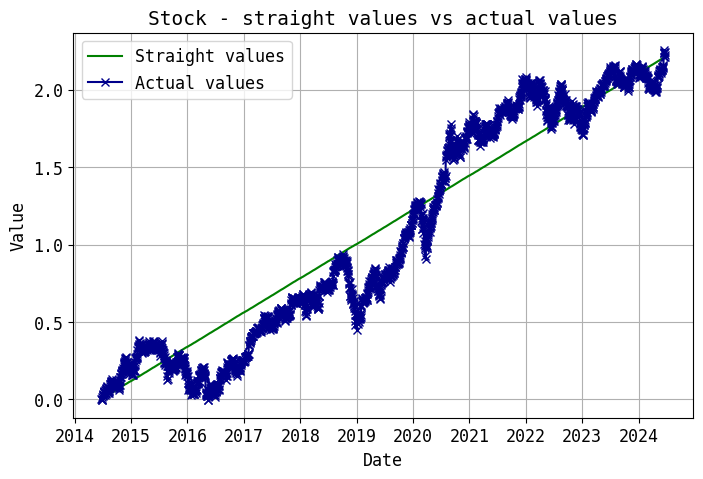

In [35]:
# daily returns ascending perfectly
daily_ret = df.log_ret.mean()
observed = pd.Series([daily_ret] * df.shape[0]).cumsum()
# cumulative sum of log returns
predicted = df.log_ret.cumsum()
# calc R^2
r_squared = r2_score(observed, predicted)
print(f"R^2: {r_squared}")
plot_r2(df.index, observed, predicted, 'Stock')

R^2: 0.6549619802721938


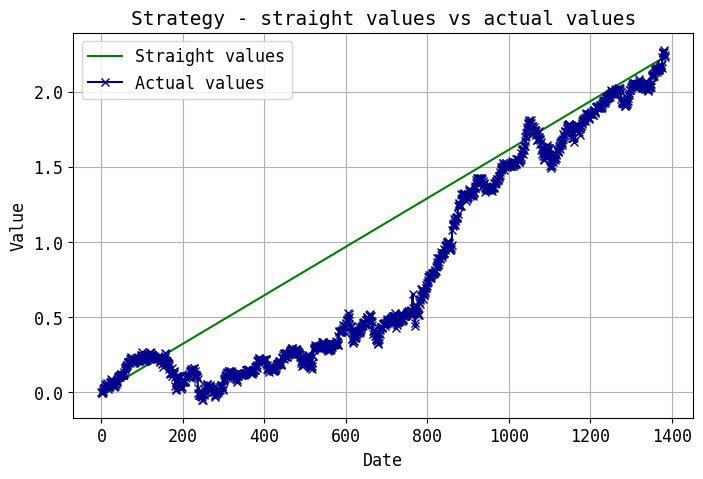

In [36]:
temp = inv_est.copy().dropna().reset_index()
# daily returns ascending perfectly
daily_ret = temp.log_ret.mean()
observed = pd.Series([daily_ret] * temp.shape[0]).cumsum()
# cumulative sum of log returns
predicted = temp.log_ret.cumsum()
# calc R^2
r_squared = r2_score(observed, predicted)
print(f"R^2: {r_squared}")
plot_r2(temp.index, observed, predicted, 'Strategy')

max drawdown

In [37]:
def plot_max_dd(returns, name):
  plt.figure(figsize=(8, 5))
  plt.subplot(2, 1, 1)
  plt.plot(returns, label='Value', color=cm(10))
  plt.title('Prices')
  plt.legend()

  plt.subplot(2, 1, 2)
  rolling_max = returns.cummax()
  drawdown = returns / rolling_max - 1
  plt.plot(drawdown, label='Drawdown', color=cm(0))
  plt.title('Drawdown')
  plt.legend()

  plt.tight_layout()
  plt.show()

Max DrawDown: -38.73%


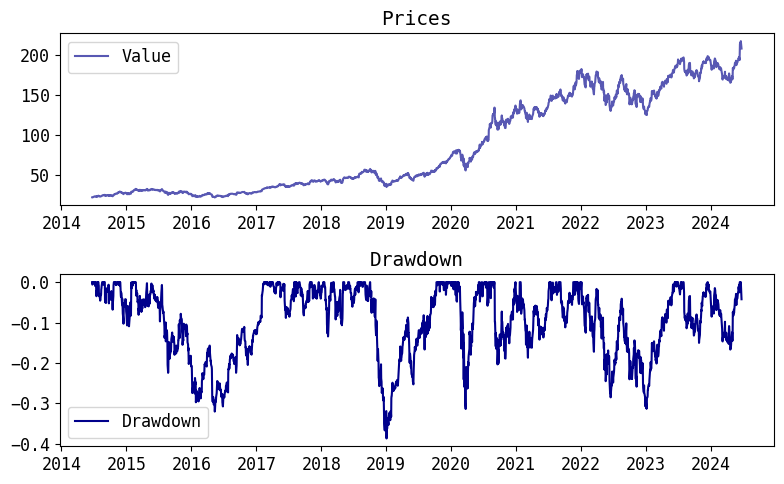

In [38]:
max_dd = calculate_max_drawdown(df.Close)
print(f"Max DrawDown: {max_dd:.2%}")
plot_max_dd(df.Close, 'Stock')

Max DrawDown: -31.90%


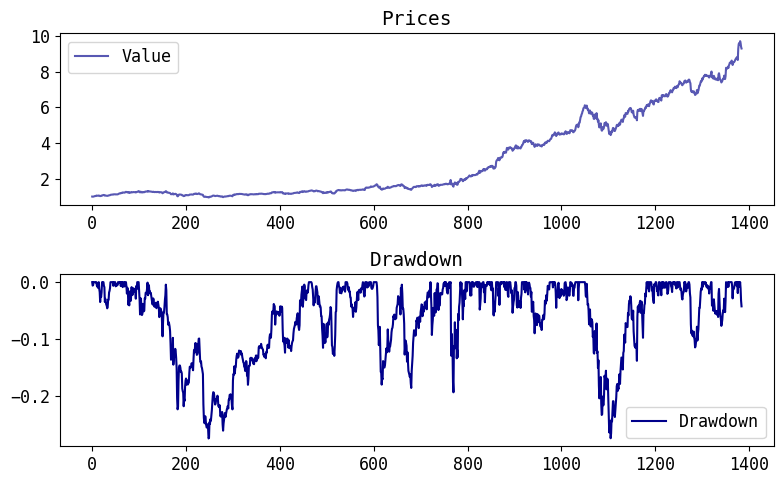

In [41]:
max_dd = calculate_max_drawdown(temp.Close)
print(f"Max DrawDown: {max_dd:.2%}")
plot_max_dd(np.exp(temp.log_ret.cumsum()), 'Strategy')